# 1. Blocker Fraud Company
 <font size="2"> Dados e problema negócio hipotéticos</font>
 
A Blocker Fraud Company é uma empresa especializada na detecção de fraudes em transações financeiras feitas atravś de dispositivos móveis.

O modelo de negócio da empresa é do tipo Serviço com a monetização feita por performance do serviço prestado, ou seja, o usuário paga uma taxa fixa sobre o sucesso da detecção de fraude das transações.

## 1.1. Estratégia de expansão

A Blocker Fraud Company está em fase de expansão no Brasil e para adquirir clientes mais rapidamente, ela adotou uma estratégia muito agressiva. A estratégia funciona da seguinte forma:

1. A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.
2. A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.
3. A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.

Com essa estratégia agressiva a empresa assume os riscos em falhar na detecção de fraude e é remunerada na detecção assertiva das fraudes.

## 1.2. Objetivo

Criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

### 1.2.1. Entregáveis

Modelo em produção no qual seu acesso será feito via API, ou seja, os clientes enviarão suas transações via API para que o seu modelo as classifique como fraudulentas ou legítimas.

Além disso, você precisará entregar um relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu. No seu relatório deve conter as respostas para as seguintes perguntas:

1. Qual a Precisão e Acurácia do modelo?
2. Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
3. Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
4. Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
5. Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?


# 2. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn import model_selection
from sklearn import ensemble
from sklearn import tree
from sklearn import linear_model
from sklearn import pipeline
from sklearn import calibration

from feature_engine import imputation
from feature_engine import encoding
from feature_engine import discretisation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve, classification_report

## 2.1. Utils functions

In [2]:
def performance(model, x_train, y_train):
    
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    scores = model_selection.cross_validate(model, x_train, y_train, cv=5, scoring=scoring)

    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

def precision_recall_curve_graph(model, x_train, y_train):
    probs = model.predict_proba(x_train)
    positive_probs = probs[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_train, positive_probs)
    no_skill = len(y_train[y_train==1]) / len(y_train)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Model')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.legend()

    plt.show()
    
def roc_curve_graph(model, x_train, y_train):
    ns_probs = [0 for _ in range(len(y_train))]

    probs = model.predict_proba(x_train)
    positive_probs = probs[:, 1]
    
    
    ns_auc = roc_auc_score(y_train, ns_probs)
    roc_auc = roc_auc_score(y_train, positive_probs)

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (roc_auc))

    ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
    model_fpr, model_tpr, _ = roc_curve(y_train, positive_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(model_fpr, model_tpr, marker='.', label='Model')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()

    plt.show()
    
def create_classification_report(model, x_train, y_train):
    y_pred = model.predict(x_train)
    return print(classification_report(y_train, y_pred))

# 3. Data

## 3.1. Load dataset

In [3]:
df = pd.read_parquet('../data/raw/df_applied_features.parquet.gzip') 

In [4]:
df_test = pd.read_parquet('../data/raw/df_applied_features_test.parquet.gzip') 

# 4. Data preparation

## 4.1. Define feature and target

In [5]:
features = df.drop('isFraud', axis=1).columns.tolist()
target = 'isFraud'

## 4.2. Split data into train and valid

In [6]:
X = df[features]
y = df[target].values

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,
                                                                      y,
                                                                      random_state=42,
                                                                      test_size=0.3,
                                                                      stratify=y)

In [7]:
cols_to_include = ['isFlaggedFraud', 'is_high_amount', 'is_M_customer', 
                   'is_new_balance_orig_zero', 'is_orig_old_balance_greater_new',
                   'is_new_balance_dest_zero', 'is_dest_old_balance_greater_new']

columns_drop = ['nameOrig', 'nameDest']

for col in cols_to_include:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')
    
X_train.drop(columns_drop, axis=1, inplace=True)
X_valid.drop(columns_drop, axis=1, inplace=True)

## 4.4. Load pipeline

In [8]:
pipe = joblib.load('../models/model_cicle_1.pkl')

# 5. Performance

## 5.1. Performance train dataset

In [9]:
performance(pipe, X_train, y_train)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.99972,0.97208,0.80710,0.88188,0.90354,0.88560


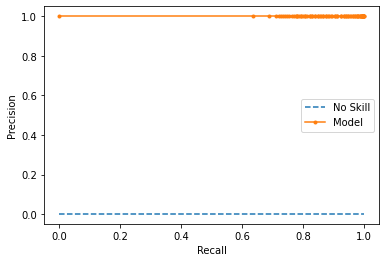

In [10]:
precision_recall_curve_graph(pipe, X_train, y_train)

No Skill: ROC AUC=0.500
Model: ROC AUC=1.000


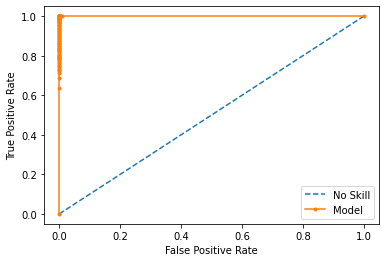

In [11]:
roc_curve_graph(pipe, X_train, y_train)

In [12]:
create_classification_report(pipe, X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4403608
           1       1.00      1.00      1.00      5687

    accuracy                           1.00   4409295
   macro avg       1.00      1.00      1.00   4409295
weighted avg       1.00      1.00      1.00   4409295



## 5.2. Performance valid dataset

In [13]:
performance(pipe, X_valid, y_valid)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.99970,0.96686,0.79162,0.87042,0.89579,0.87467


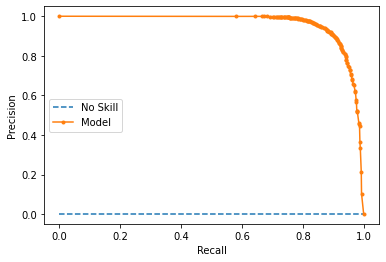

In [14]:
precision_recall_curve_graph(pipe, X_valid, y_valid)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.996


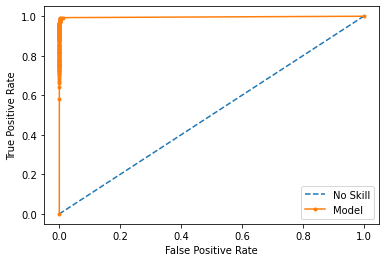

In [15]:
roc_curve_graph(pipe, X_valid, y_valid)

In [16]:
create_classification_report(pipe, X_valid, y_valid)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1887261
           1       0.97      0.83      0.89      2438

    accuracy                           1.00   1889699
   macro avg       0.99      0.91      0.95   1889699
weighted avg       1.00      1.00      1.00   1889699



## 5.3. Performance test dataset

In [17]:
X_test = df_test[features].copy()
y_test = df_test[target]


for col in cols_to_include:
    X_test[col] = X_test[col].astype('category')
    
X_test.drop(columns_drop, axis=1, inplace=True)

In [18]:
performance(pipe, X_test, y_test)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.99958,0.95673,0.72680,0.82421,0.86338,0.83274


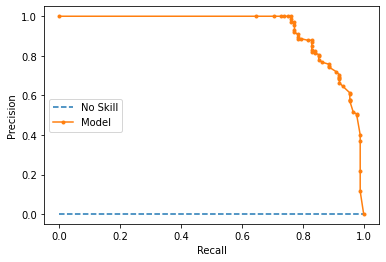

In [19]:
precision_recall_curve_graph(pipe, X_test, y_test)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.994


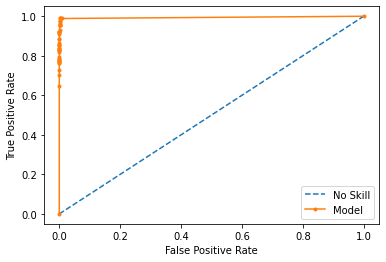

In [20]:
roc_curve_graph(pipe,  X_test, y_test)

In [21]:
create_classification_report(pipe, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63538
           1       0.92      0.77      0.84        88

    accuracy                           1.00     63626
   macro avg       0.96      0.89      0.92     63626
weighted avg       1.00      1.00      1.00     63626



### 5.3.1. Diagnose calibration

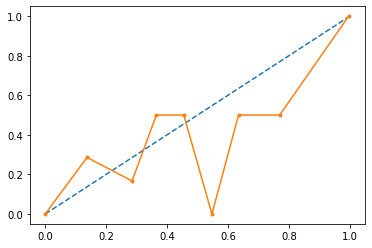

In [22]:
probs = pipe.predict_proba(X_test)[:,1]

fop, mpv = calibration.calibration_curve(y_test, probs, n_bins=10, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

## 5.4. Calibration classifier

In [23]:
calibrator = calibration.CalibratedClassifierCV(pipe, cv=5)
calibrator.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('enconding_rare',
                                                       RareLabelEncoder(variables=['type',
                                                                                   'isFlaggedFraud'])),
                                                      ('enconding_cat',
                                                       CountFrequencyEncoder(variables=['is_new_balance_dest_zero',
                                                                                        'type',
                                                                                        'is_orig_old_balance_greater_new',
                                                                                        'is_M_customer',
                                                                                        'is_high_amount',
                                                                                        'is_new_balance_orig_zero'

### 5.4.1. Calibration performance

In [24]:
performance(calibrator, X_test, y_test)

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.99956,0.97212,0.70458,0.81371,0.85227,0.82571


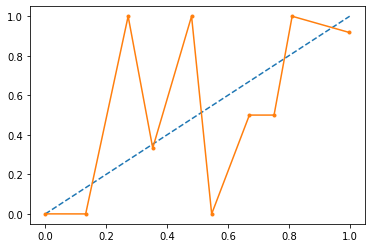

In [25]:
probs = calibrator.predict_proba(X_test)[:, 1]

fop, mpv = calibration.calibration_curve(y_test, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

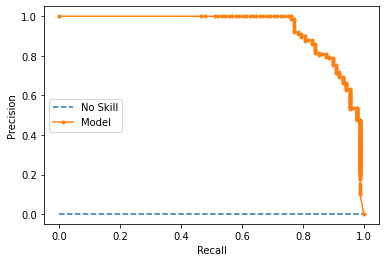

In [26]:
precision_recall_curve_graph(calibrator, X_test, y_test)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.994


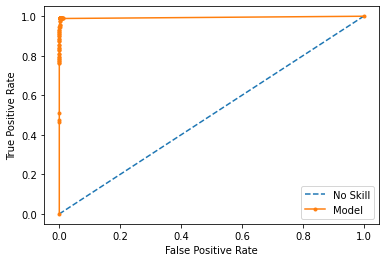

In [27]:
roc_curve_graph(calibrator,  X_test, y_test)

In [28]:
create_classification_report(calibrator, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63538
           1       0.88      0.81      0.84        88

    accuracy                           1.00     63626
   macro avg       0.94      0.90      0.92     63626
weighted avg       1.00      1.00      1.00     63626



### 5.4.2. Saving calibrator model

In [29]:
joblib.dump(calibrator, '../models/model_calibrated_cicle_1.pkl', compress = 1)

['../models/model_calibrated_cicle_1.pkl']

# 6. Conclusion

Iniciamos a avaliação da performance do modelo com os dados de treino onde podemos perceber uma alta performance nos dados onde o modelo foi treinado, evidenciando que é possível que o modelo seja ensinado a partir dos dados oferecidos pela empresa, porém devemos validar o modelo com dados onde ele não foi treinado, que são os dados de validação, e mesmo assim o modelo se sai bem mesmo com dados que não foram apresentados à ele.

Para que possamos criar um cenário para testar como o modelo se sairá em produção, os dados de teste foi separado desde o início do projeto (notebook 1) existindo assim uma queda na performace porém está em um nível aceitável de precision e recall, tornando o modelo válido para os próximos passos.

A calibração do modelo de classificação utiliza as probabilidades dos registros ser rotulados com o nosso target, ajudando o modelo a calibrar qual será a melhor probabilidade para prever a classe do registro. Neste ciclo estamos usando RandomForest para previsão, o calibrador irá auxiliar na predição das probabilidade e possivelmente aumentar a sua performance, é o que vimos no resultado, tivemos aumento na sua precision e consequentemente na f1-score, mas a recall caiu, como estamos no primeiro ciclo vamos continuar com o modelo anterior pelo fato que gostariamos que o modelo tenha um recall alto.